<a href="https://colab.research.google.com/github/tigju/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/LS_DS_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [3]:
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,...,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,...,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df['perks'] = df['elevator'] + df['cats_allowed'] + df['dogs_allowed'] + df['hardwood_floors'] + df['doorman'] + df['dishwasher'] + df['laundry_in_building'] + df['laundry_in_unit'] + df['fitness_center'] + df['roof_deck'] + df['outdoor_space'] + df['dining_room'] + df['high_speed_internet'] + df['balcony'] + df['swimming_pool'] + df['terrace'] + df['garden_patio'] + df['wheelchair_access'] + df['common_outdoor_space']

df['perks']          

0        0
1        5
2        3
3        1
4        0
        ..
49347    4
49348    8
49349    4
49350    4
49351    1
Name: perks, Length: 48817, dtype: int64

In [5]:
df['total_rooms_num'] = df['bathrooms'] + df['bedrooms']
df['total_rooms_num']

0        4.5
1        3.0
2        2.0
3        2.0
4        5.0
        ... 
49347    3.0
49348    2.0
49349    2.0
49350    1.0
49351    3.0
Name: total_rooms_num, Length: 48817, dtype: float64

In [6]:
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
df['created'].dtype

dtype('<M8[ns]')

In [7]:
df['month'] = df['created'].dt.month

In [8]:
df['month'].value_counts()

6    16973
4    16217
5    15627
Name: month, dtype: int64

In [9]:
train = df[df['month'] != 6]

In [10]:
test = df[df['month'] == 6]

In [11]:
train.shape, test.shape

((31844, 37), (16973, 37))

In [69]:
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "svg"

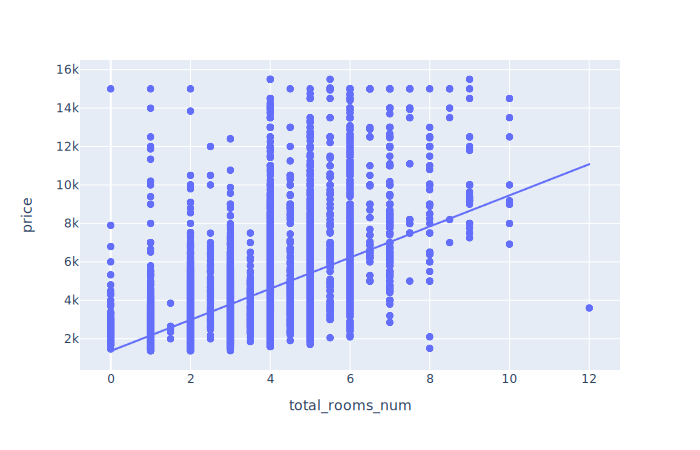

In [70]:
px.scatter(train,
           x='total_rooms_num',
           y='price',
           trendline='ols')

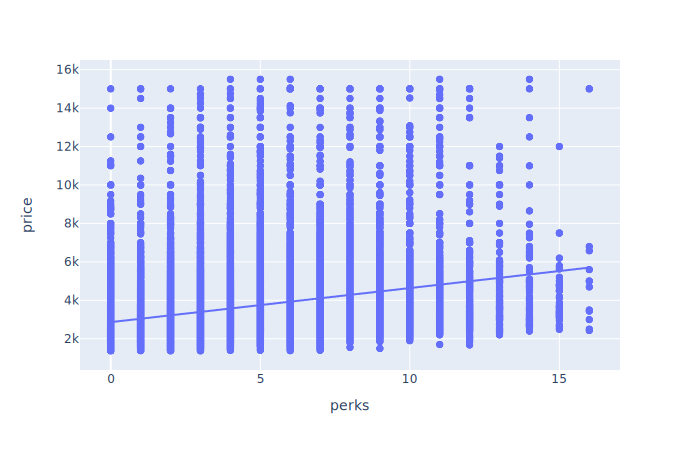

In [71]:
px.scatter(train,
           x='perks',
           y='price',
           trendline='ols')

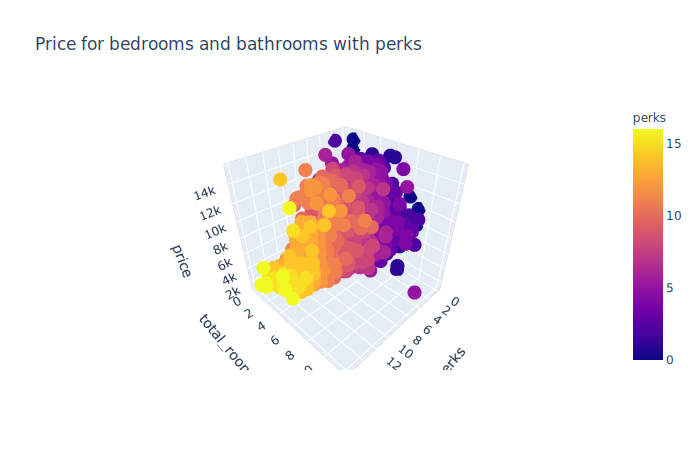

In [72]:
px.scatter_3d(
    train,
    x='perks',
    y='total_rooms_num',
    z='price',
    title='Price for bedrooms and bathrooms with perks',
    color='perks'
)

In [73]:
# Step 1
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [74]:
# Step 2
model = LinearRegression()
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [75]:
# step 3 define target vector and feature matrix
features = ['perks', 'total_rooms_num']
target = 'price'
X_train = df[features]
y_train = df[target]
X_test = test[features]
y_test = test[target]

In [76]:
# check matrix shape and vector shape
print(X_train.shape)
print(y_train.shape)

(48817, 2)
(48817,)


In [77]:
# step 4 fit the model
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train)
print(f'Train Error: {mae:.2f} in dollars')

Train Error: 855.64 in dollars


In [78]:
# step 5 apply my model to new data
y_pred_test = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test)
print(f'Test Error: {mae:.2f} in dollars')

Test Error: 861.79 in dollars


In [79]:
import itertools
import numpy as np
import plotly.express as px
import plotly.graph_objs as go

def regression_3d(df, x, y, z, num=100, **kwargs):
    """
    Visualize linear regression in 3D: 2 features + 1 target
    
    df : Pandas DataFrame
    x : string, feature 1 column in df
    y : string, feature 2 column in df
    z : string, target column in df
    num : integer, number of quantiles for each feature
    """
    
    # Plot data
    fig = px.scatter_3d(df, x, y, z, **kwargs)
    
    # Fit Linear Regression
    features = [x, y]
    target = z
    model = LinearRegression()
    model.fit(df[features], df[target])    
    
    # Define grid of coordinates in the feature space
    xmin, xmax = df[x].min(), df[x].max()
    ymin, ymax = df[y].min(), df[y].max()
    xcoords = np.linspace(xmin, xmax, num)
    ycoords = np.linspace(ymin, ymax, num)
    coords = list(itertools.product(xcoords, ycoords))
    
    # Make predictions for the grid
    predictions = model.predict(coords)
    Z = predictions.reshape(num, num).T
    
    # Plot predictions as a 3D surface (plane)
    fig.add_trace(go.Surface(x=xcoords, y=ycoords, z=Z))
    
    return fig

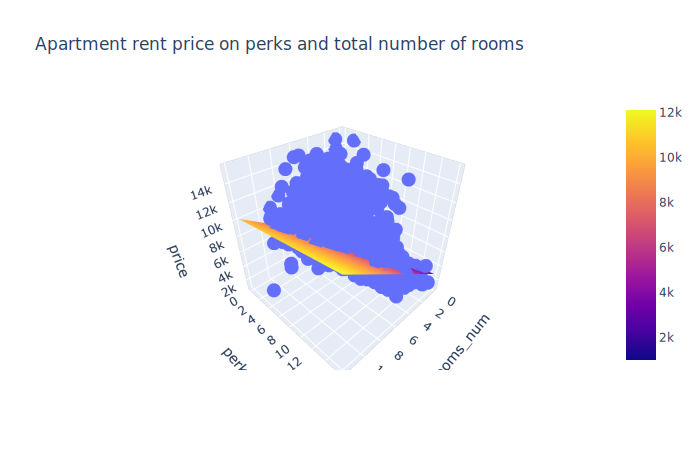

In [80]:
regression_3d(
    train,
    x='total_rooms_num', 
    y='perks', 
    z='price',  
    title='Apartment rent price on perks and total number of rooms'
)

In [81]:
# find coefficient and intercept
model.intercept_, model.coef_

(995.61207502264, array([121.90739186, 766.18821796]))

In [82]:
beta0 = model.intercept_
beta1, beta2 = model.coef_
print(f'y = {beta0:.2f} + {beta1:.2f}*x1 + {beta2:.2f}*x2')

y = 995.61 + 121.91*x1 + 766.19*x2


In [83]:
# This is easier to read
print('Intercept', model.intercept_)
coefficients = pd.Series(model.coef_, features)
print(coefficients.to_string())

Intercept 995.61207502264
perks              121.907392
total_rooms_num    766.188218


In [84]:
model.predict([[0, 0]])

array([995.61207502])

In [85]:
model.predict([[1, 0]])

array([1117.51946689])

In [86]:
model.predict([[16, 12]])

array([12140.38896036])

In [87]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [88]:
def errors_output(act,pred):
  mae = mean_absolute_error(act, pred)
  mse = mean_squared_error(act, pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(act, pred)

  print(f'Mean Absolute Error: {mae}')
  print(f'Mean Squared Error: {mse}')
  print(f'Root of Mean Squared Error: {rmse}')
  print(f'R^2: {r2}')

In [89]:
print('Train data:')
errors_output(y_train, y_pred_train)

Train data:
Mean Absolute Error: 855.644690764102
Mean Squared Error: 1659858.5120797781
Root of Mean Squared Error: 1288.35496354063
R^2: 0.46561306416742465


In [90]:
print('Test data:')
errors_output(y_test, y_pred_test)

Test data:
Mean Absolute Error: 861.7870861773415
Mean Squared Error: 1653422.7389396874
Root of Mean Squared Error: 1285.8548669813742
R^2: 0.4680143421019466
